# Practice PS07: Outlier analysis

The objective of this session is to practice finding outliers by implementing the [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest) algorithm.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Shaoya Zhang</font>

E-mail: <font color="blue">shaoya.zhang01@estudiant.upf.edu</font>

Date: <font color="blue">2025-11-13</font>

In [1]:
# LEAVE THIS CELL AS-IS

import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np

# 1. Dataset

We will use two datasets: 

* The [Thyroid dataset](http://odds.cs.stonybrook.edu/annthyroid-dataset/) with exams of the thyroid gland of 7,200 patients.
* The [Cardiotocography dataset](https://shebuti.com/cardiotocogrpahy-dataset/) with exams of fetal heart rate and uterine contractions of 1,831 patients.

In both datasets the attributes are named *f1*, *f2*, ... and there is a *result* label indicating whether a clinician considered the situation *normal* or *abnormal*.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [2]:
# LEAVE THIS CELL AS-IS

dft = pd.read_csv('annthyroid.csv', sep=',')
dfc = pd.read_csv('cardio.csv', sep=',')

In [3]:
display(dft.head(5))
display(dfc.head(5))

,f1,f2,f3,f4,f5,f6,label
0,0.73,0.00060,0.015,0.120,0.082,0.146,0.0
1,0.24,0.00025,0.030,0.143,0.133,0.108,0.0
2,0.47,0.00190,0.024,0.102,0.131,0.078,0.0
3,0.64,0.00090,0.017,0.077,0.090,0.085,0.0
4,0.23,0.00025,0.026,0.139,0.090,0.153,0.0


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f13,f14,f15,f16,f17,f18,f19,f20,f21,result
0,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,-0.420487,...,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294,normal
1,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,-0.420487,...,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294,normal
2,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018,normal
3,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018,normal
4,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,-0.420487,...,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018,normal


In [23]:
# There is no feature 'result' in the data file annthyroid.csv, so I modified the data
dft['label'] = dft['label'].map({0: 'normal', 1: 'abnormal'})
dft = dft.rename(columns={'label': 'result'})

Print the total number of patients, the number and percentage of patients with normal and abnormal exams. Your code should write:

```
Thyroid dataset containing 7200 patients
Normal   : 6666 (92.58%)
Abnormal : 534 (7.42%)

Cardio dataset containing 1831 patients
Normal   : 1655 (90.39%)
Abnormal : 176 (9.61%)
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to print the number and percentages of patients in each group.</font>

In [24]:
tot_thy = dft['result'].count()
print(f"Thyroid dataset containing {tot_thy} patients")
label_counts = dft['result'].value_counts()
label_ratio = label_counts / tot_thy
# 0 -> normal / 1-> abnormal
print(f"Normal  : {label_counts[0]} ({round(label_ratio[0] * 100, 2)}%)")
print(f"Abormal  : {label_counts[1]} ({round(label_ratio[1] * 100, 2)}%)")

tot_cardio = dfc['result'].count()
print(f"\nCardio dataset containing {tot_cardio} patients")
ret_counts = dfc['result'].value_counts()
ret_ratio = ret_counts / tot_cardio
print(f"Normal  : {ret_counts['normal']} ({round(ret_ratio['normal'] * 100, 2)}%)")
print(f"Abormal  : {ret_counts['abnormal']} ({round(ret_ratio['abnormal'] * 100, 2)}%)")

Thyroid dataset containing 7200 patients
Normal  : 6666 (92.58%)
Abormal  : 534 (7.42%)

Cardio dataset containing 1831 patients
Normal  : 1655 (90.39%)
Abormal  : 176 (9.61%)


C:\Users\zsy\AppData\Local\Temp\ipykernel_7808\3089465752.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Normal  : {label_counts[0]} ({round(label_ratio[0] * 100, 2)}%)")
C:\Users\zsy\AppData\Local\Temp\ipykernel_7808\3089465752.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Abormal  : {label_counts[1]} ({round(label_ratio[1] * 100, 2)}%)")


## 1.1. Centroid inspection for the "thyroid" dataset

To have a first idea on whether a dataset contains relevant features for outlier detection, there are various methods. One of them is to determine the centroid of normal and abnormal points.

Print the first 10 normal exams, and the "centroid" (average) of a normal exam in the `thyroid` dataset.

Print the first 10 abnormal exams, and the "centroid" (average) of a normal exam in the `thyroid` dataset.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to print the 10 normal exams in the `thyroid` dataset and the centroid of all normal exams, and the first 10 abnormal exams and the centroid of all abnormal exams.</font>

In [26]:
# 0 -> normal / 1-> abnormal
# normal = dft[dft['label'] == 0].drop(columns=['label'])
# abnormal = dft[dft['label'] == 1].drop(columns=['label'])
normal = dft[dft['result'] == 'normal'].drop(columns=['result'])
abnormal = dft[dft['result'] == 'abnormal'].drop(columns=['result'])

# centroids
centroid_normal = normal.mean()
centroid_abnormal = abnormal.mean()

print(f"First 10 normal exams:")
display(normal.head(10))
print("\nCentroid (average) of normal exams:")
print(centroid_normal)

print("\nFirst 10 abnormal exams:")
display(abnormal.head(10))
print("\nCentroid (average) of abnormal exams:")
print(centroid_abnormal)

First 10 normal exams:


,f1,f2,f3,f4,f5,f6
0,0.73,0.00060,0.015,0.120,0.082,0.146
1,0.24,0.00025,0.030,0.143,0.133,0.108
2,0.47,0.00190,0.024,0.102,0.131,0.078
3,0.64,0.00090,0.017,0.077,0.090,0.085
4,0.23,0.00025,0.026,0.139,0.090,0.153
5,0.69,0.00025,0.016,0.086,0.070,0.123
6,0.85,0.00025,0.023,0.128,0.104,0.121
7,0.48,0.00208,0.020,0.086,0.078,0.110
8,0.67,0.00130,0.024,0.087,0.109,0.080
9,0.76,0.00010,0.029,0.124,0.128,0.097



Centroid (average) of normal exams:
f1    0.518314
f2    0.002098
f3    0.020384
f4    0.112193
f5    0.097705
f6    0.116132
dtype: float64

First 10 abnormal exams:


,f1,f2,f3,f4,f5,f6
10,0.62,0.01100,0.0080,0.0730,0.074,0.0980
19,0.50,0.06100,0.0096,0.0130,0.116,0.0110
27,0.78,0.02500,0.0090,0.0500,0.084,0.0600
43,0.61,0.00979,0.0040,0.0810,0.064,0.1260
84,0.56,0.00820,0.0200,0.0660,0.094,0.0700
105,0.73,0.04700,0.0110,0.0520,0.090,0.0580
115,0.43,0.07000,0.0050,0.0029,0.104,0.0028
116,0.42,0.03100,0.0080,0.0130,0.119,0.0110
145,0.78,0.00630,0.0110,0.0560,0.086,0.0650
147,0.53,0.02500,0.0040,0.0390,0.061,0.0640



Centroid (average) of abnormal exams:
f1    0.548034
f2    0.039363
f3    0.014891
f4    0.074940
f5    0.099500
f6    0.076803
dtype: float64


<font size="+1" color="red">Replace this cell with a brief comment indicating, based only on the centroids, which features do you think could be useful for differentiating between normal and abnormal thyroids? Why?</font>

## 1.2. Scatter plot inspection for the "cardio" dataset 

A second idea is to use scatter plots to look at combination of features. Identifying outliers is easier when outliers are different, across many dimensions, from inliers. 

To show this, we can create all scatter plots of combinations of two dimensions in the data. In these, you can see that feature values for the minority class (represented by the color red), indeed are quite different from feature values for the majority class (represented by the color blue).

Use [scatter_matrix](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html) to create a matrix of scatter plots. The following code creates a simple scatter matrix. Pick color1 and color2 from the list of [matplotlib colors](https://matplotlib.org/stable/gallery/color/named_colors.html).

```python
color_code = {'abnormal': ..., 'normal': ...}

colors = df['result'].apply(lambda x: color_code[x])

pd.plotting.scatter_matrix(df, c=colors)
```

Change the figure size with parameter `figsize`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to create a scatter matrix as described above.</font>

array([[<Axes: xlabel='f1', ylabel='f1'>,
        <Axes: xlabel='f2', ylabel='f1'>,
        <Axes: xlabel='f3', ylabel='f1'>,
        <Axes: xlabel='f4', ylabel='f1'>,
        <Axes: xlabel='f5', ylabel='f1'>,
        <Axes: xlabel='f6', ylabel='f1'>,
        <Axes: xlabel='f7', ylabel='f1'>,
        <Axes: xlabel='f8', ylabel='f1'>,
        <Axes: xlabel='f9', ylabel='f1'>,
        <Axes: xlabel='f10', ylabel='f1'>,
        <Axes: xlabel='f11', ylabel='f1'>,
        <Axes: xlabel='f12', ylabel='f1'>,
        <Axes: xlabel='f13', ylabel='f1'>,
        <Axes: xlabel='f14', ylabel='f1'>,
        <Axes: xlabel='f15', ylabel='f1'>,
        <Axes: xlabel='f16', ylabel='f1'>,
        <Axes: xlabel='f17', ylabel='f1'>,
        <Axes: xlabel='f18', ylabel='f1'>,
        <Axes: xlabel='f19', ylabel='f1'>,
        <Axes: xlabel='f20', ylabel='f1'>,
        <Axes: xlabel='f21', ylabel='f1'>],
       [<Axes: xlabel='f1', ylabel='f2'>,
        <Axes: xlabel='f2', ylabel='f2'>,
        <Axes: xlabel

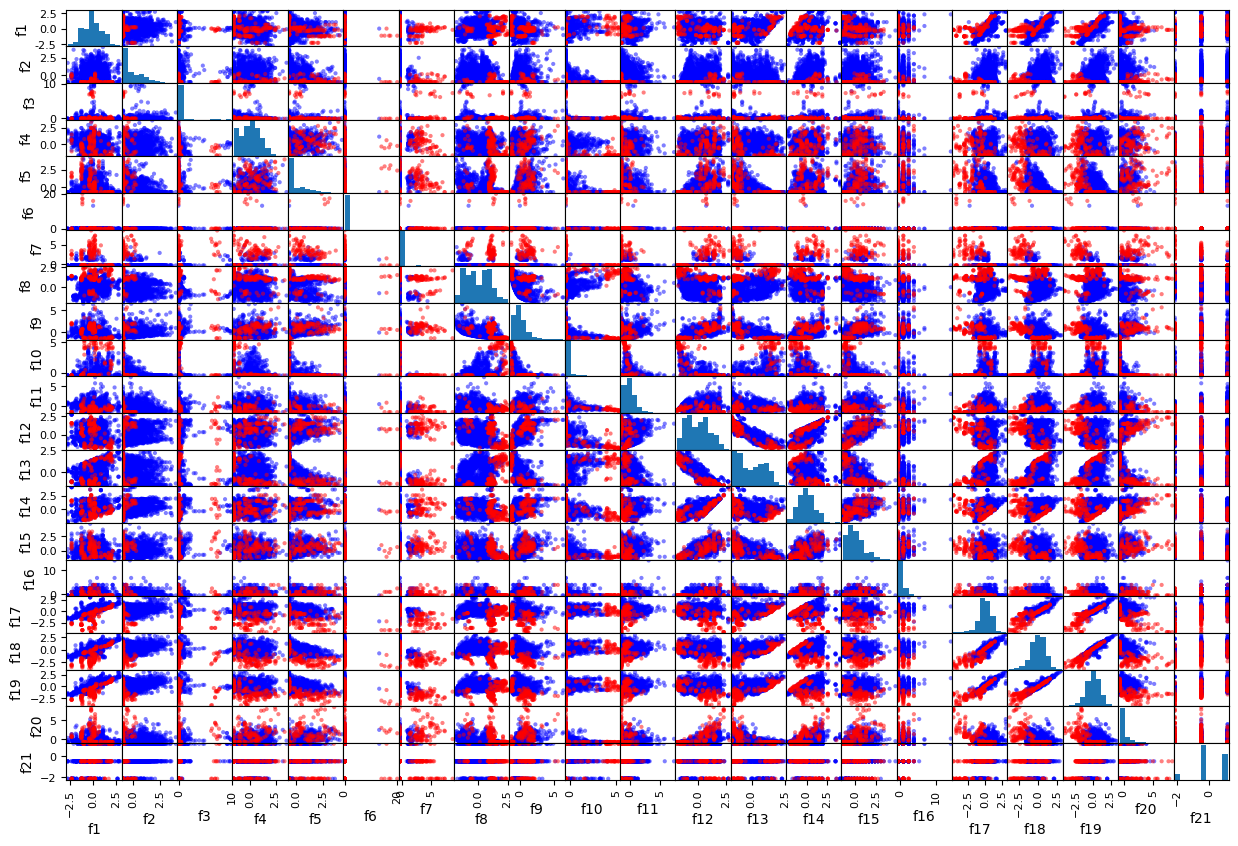

In [27]:
color_code = {'abnormal': 'red', 'normal': 'blue'}
colors = dfc['result'].apply(lambda x: color_code[x])
# pd.plotting.scatter_matrix(dfc, c = colors, figsize=(15, 10))
pd.plotting.scatter_matrix(
    dfc.drop(columns=['result']),  
    c=colors,
    figsize=(15, 10)
)

<font size="+1" color="red">Replace this cell with a brief commentary on whether you already guess any difference between normal and abnormal exams, based on combinations of features. What are the differences you can appreciate?</font>

# 1. Create isolation tree

## 1.1. Random dimension and random split

Create a function that returns a random dimension in the dataset. We will ignore some columns, because the random dimension can never be *id* or *result*, but instead should be one of the other dimensions 'f1', 'f2', ..., 'f6'. Do not hard-code these dimensions into your function, instead, read df.columns.

The signature of your function should be `pick_random_dimension(df, columns_to_ignore)`.

Test your function by calling it a few times. It should return a random dimension every time, among the columns of the dataset, excluding the *columns_to_ignore*.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code implementing "pick_random_dimension".

In [28]:
def pick_random_dimension(df, columns_to_ignore):
    df_new = df.drop(columns = columns_to_ignore)
    num_cols = df_new.shape[1]
    idx = random.randint(0, num_cols - 1)
    return df_new.columns[idx]

The following code tests your function.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [29]:
# LEAVE THIS CODE AS-IS
# Testing code

print("Random dimensions for the 'thyroid' dataset")
print(pick_random_dimension(dft, ["result"]))
print(pick_random_dimension(dft, ["result"]))
print()

print("Random dimensions for the 'cardio' dataset")
print(pick_random_dimension(dfc, ["result"]))
print(pick_random_dimension(dfc, ["result"]))

Random dimensions for the 'thyroid' dataset
f5
f5

Random dimensions for the 'cardio' dataset
f16
f2


Create a function that returns a split point chosen uniformly at random along a dimension. Use `np.min(df[dimension])` and `np.max(df[dimension])` to determine the bounds.

The signature of your function should be `pick_random_split(df, dimension)`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code implementing "pick_random_split" and a couple of calls to test this function; each call should return a random split point chosen uniformly at random between the minimum and the maximum value along a dimension.</font>

In [30]:
def pick_random_split(df, dimension):
    lo = np.min(df[dimension])
    hi = np.max(df[dimension])
    return np.random.uniform(lo, hi)

The following code tests your function. Note that in the `thyroid` dataset features are normalized to be in the unit interval, but in `cardio` the features are not normalized.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [31]:
# LEAVE THIS CODE AS-IS

print("Random splits according to 'f4' in the 'thyroid' dataset")
print(pick_random_split(dft, "f4"))
print(pick_random_split(dft, "f4"))
print()
print("Random splits according to 'f15' in the 'cardio' dataset")
print(pick_random_split(dfc, "f15"))
print(pick_random_split(dfc, "f15"))

Random splits according to 'f4' in the 'thyroid' dataset
0.5203877832738646
0.2935805540577988

Random splits according to 'f15' in the 'cardio' dataset
-0.9924104025505893
3.5769606114753243


## 1.2. Implement split data into two

Implement a function `split_dataset(df, dimension, split)` that returns two sub-datasets: one with all elements having *dimension <= split*, and another one with all elements having *dimension > split*.

The signature of your function should be `split_dataset(df, dimension, split)`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code implementing "split_dataset".</font>

In [32]:
def split_dataset(df, dimension, split):
    left = df[df[dimension] <= split]
    right = df[df[dimension] > split]
    return left, right

Remember to test your function; for instance, split on dimension `f1` at `0.5` by doing:

```python
(left, right) = split_dataset(df, 'f1', 0.5)
```

In the output, all the rows in `left` have f1 <= 0.5 and all the rows in `right` have f1 > 0.5.

Print the number of rows in each side (left, right) and the total number of rows in the input. These sum of left plus right should be the total.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code testing "split_dataset", i.e., select a dataset, a dimension, and a cut-off, and split the dataset, then print the two pieces and check that it is working correctly. Also check that the sum of the sizes of the two pieces is the size of the original data.</font>

In [33]:
print("Random splits according to 'f1' in the 'thyroid' dataset")
split = pick_random_split(dft, "f1")
left, right = split_dataset(dft, "f1", split)
print(f"Split value: {split:.4f}")
print("Left subset:\n", left)
print("\nRight subset:\n", right)
assert((len(left) + len(right) == len(dft['f1'])))
print("\n")
print("Random splits according to 'f20' in the 'cardio' dataset")
split2 = pick_random_split(dfc, "f20")
left2, right2 = split_dataset(dfc, "f20", split2)
print(f"Split value: {split2:.4f}")
print("left subset:\n", left2)
print("right subset:\n", right2)
assert((len(left2) + len(right2) == len(dfc['f20'])))

Random splits according to 'f1' in the 'thyroid' dataset
Split value: 0.9554
Left subset:
         f1       f2      f3     f4     f5      f6    result
0     0.73  0.00060  0.0150  0.120  0.082  0.1460    normal
1     0.24  0.00025  0.0300  0.143  0.133  0.1080    normal
2     0.47  0.00190  0.0240  0.102  0.131  0.0780    normal
3     0.64  0.00090  0.0170  0.077  0.090  0.0850    normal
4     0.23  0.00025  0.0260  0.139  0.090  0.1530    normal
...    ...      ...     ...    ...    ...     ...       ...
7195  0.59  0.00250  0.0208  0.079  0.099  0.0800    normal
7196  0.51  0.10600  0.0060  0.005  0.089  0.0055  abnormal
7197  0.51  0.00076  0.0201  0.090  0.067  0.1340    normal
7198  0.35  0.00280  0.0201  0.090  0.089  0.1010    normal
7199  0.73  0.00056  0.0201  0.081  0.090  0.0900    normal

[7198 rows x 7 columns]

Right subset:
         f1      f2     f3     f4     f5     f6  result
5547  0.97  0.0029  0.005  0.101  0.064  0.158  normal
5548  0.97  0.0023  0.018  0.093  0.08

## 1.3. Create one isolation tree

First, let us add a patient identifier in column "id". The new dataframe is called `dfi`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [34]:
# LEAVE THIS COLUMN AS-IS

dfti = dft.copy()
dfti.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(dft))])
display(dfti.head(5))

dfci = dfc.copy()
dfci.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(dfc))])
display(dfci.head(5))

,id,f1,f2,f3,f4,f5,f6,result
0,P0001,0.73,0.00060,0.015,0.120,0.082,0.146,normal
1,P0002,0.24,0.00025,0.030,0.143,0.133,0.108,normal
2,P0003,0.47,0.00190,0.024,0.102,0.131,0.078,normal
3,P0004,0.64,0.00090,0.017,0.077,0.090,0.085,normal
4,P0005,0.23,0.00025,0.026,0.139,0.090,0.153,normal


,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f13,f14,f15,f16,f17,f18,f19,f20,f21,result
0,P0001,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,...,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294,normal
1,P0002,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,...,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294,normal
2,P0003,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,...,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018,normal
3,P0004,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,...,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018,normal
4,P0005,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,...,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018,normal


An isolation tree will be a dictionary. In this dictionary, having *contents*, indicates an external node of the tree, while having *left* and *right* indicates an internal node of the tree.

Create a recursive function `isolation_tree(data, columns_to_ignore, min_items)` that:

* If the *data* has *min_items* or less:
    * Return a dictionary `{"contents": data}`
* If the *data* has more than *min_items*
    * Selects a random dimension from the data, ignoring the *columns_to_ignore*
    * Selects a random split point along that dimension
    * Sets `left` to an isolation tree containing points having dimension <= split
    * Sets `right` to an isolation tree containing points having dimension > split
    * Returns a dictionary `{"left": left, "right": right, "dimension": dimension, "split": split}`

You can use the following skeleton:

```python
def isolation_tree(data, columns_to_ignore, min_items):
    tree = {}
    if len(data) <= min_items:
        return {"contents": data}
    else:
        # REPLACE WITH YOUR CODE 
        return tree   
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with you code implementing "isolation_tree".</font>

In [35]:
def isolation_tree(data, columns_to_ignore, min_items):
    tree = {}
    if len(data) <= min_items:
        return {"contents": data}
    else:
        # REPLACE WITH YOUR CODE 
        dimension = pick_random_dimension(data, columns_to_ignore)
        split = pick_random_split(data, dimension)
        left, right = split_dataset(data, dimension, split)
        tree["dimension"] = dimension
        tree["split"] = split
        tree["left"] = isolation_tree(left, columns_to_ignore, min_items)
        tree["right"] = isolation_tree(right, columns_to_ignore, min_items)
        return tree

The following auxiliary function prints a tree in ASCII.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [36]:
# LEAVE THIS CODE AS-IS

class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value)+"\n"
        if self.left:
            ret += self.left.__str__("<", level+1)
        if self.right:
            ret += self.right.__str__(">", level+1)
        return ret

    def __repr__(self):
        return self.value
    
def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['result'] == 'normal'])
        abnormal_count = len(data[data['result'] == 'abnormal'])
        description = "external node: %d normal + %d abnormal" % (normal_count, abnormal_count)
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = 'internal node: ' + tree['dimension'] + ' <= ' + ("%.2f" % tree['split'])
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right) )
        return n

Test your function creating a shallow tree.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [38]:
# LEAVE THIS CODE AS-IS

mytree_thyroid = isolation_tree(dfti, ['id', 'result'], 2000)
mytree_cardio = isolation_tree(dfci, ['id', 'result'], 200)

Print your tree using this function. It should look something like this:

```
:'internal node: f4 <= 0.30'
-<:'internal node: f3 <= 0.03'
--<:'internal node: f5 <= 0.07'
---<:'external node: 226 normal + 16 abnormal'
--->:'internal node: f6 <= 0.12'
----<:'external node: 4215 normal + 473 abnormal'
---->:'external node: 1641 normal + 34 abnormal'
-->:'external node: 576 normal + 11 abnormal'
->:'external node: 8 normal + 0 abnormal'
```

Given that the tree is created by a **randomized process**, your tree will be different.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [46]:
# LEAVE THIS CODE AS-IS

print("Tree built on the 'thyroid' dataset")
print(tree_to_nodes(mytree_thyroid))
print()

print("Tree built on the 'cardio' dataset")
print(tree_to_nodes(mytree_cardio))
print()

Tree built on the 'thyroid' dataset
:'internal node: f5 <= 0.22'
-<:'internal node: f1 <= 0.45'
--<:'internal node: f2 <= 0.40'
---<:'internal node: f4 <= 0.41'
----<:'internal node: f6 <= 0.17'
-----<:'internal node: f5 <= 0.19'
------<:'internal node: f5 <= 0.05'
-------<:'external node: 14 normal + 0 abnormal'
------->:'internal node: f5 <= 0.14'
--------<:'internal node: f6 <= 0.12'
---------<:'external node: 1469 normal + 137 abnormal'
--------->:'external node: 745 normal + 10 abnormal'
-------->:'external node: 145 normal + 5 abnormal'
------>:'external node: 9 normal + 0 abnormal'
----->:'external node: 128 normal + 0 abnormal'
---->:'external node: 4 normal + 0 abnormal'
--->:'external node: 0 normal + 6 abnormal'
-->:'internal node: f3 <= 0.07'
---<:'internal node: f4 <= 0.06'
----<:'external node: 84 normal + 99 abnormal'
---->:'internal node: f3 <= 0.01'
-----<:'external node: 122 normal + 16 abnormal'
----->:'internal node: f6 <= 0.11'
------<:'internal node: f6 <= 0.09'
-

Create a function `get_max_tree_depth` that returns the maximum depth of a tree.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with you code implementing `get_max_tree_depth`</font>

In [47]:
def get_max_tree_depth(tree):
    if 'contents' in tree:
        return 1
    left_depth = get_max_tree_depth(tree['left'])
    right_depth = get_max_tree_depth(tree['right'])
    return 1 + max(left_depth, right_depth)

The next cell tests your function. Check visually that the results are correct by looking at the printing of the trees above. This should match the maximum number of internal nodes, including the root, between the root and an external node.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [48]:
# LEAVE THIS CODE AS-IS
# Testing code

print("Depth of the random tree you built over the 'thyroid' dataset")
print(get_max_tree_depth(mytree_thyroid))
print()

print("Depth of the random tree you built over the 'cardio' dataset")
print(get_max_tree_depth(mytree_cardio))
print()

Depth of the random tree you built over the 'thyroid' dataset
10

Depth of the random tree you built over the 'cardio' dataset
16



# 2. Create isolation forests and find depth of items

An isolation forest will be simply a an array of isolation trees.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 2.1. Create an isolation forest

Write a function `isolation_forest(df, columns_to_ignore, min_items, num_trees)` that creates an array of *num_trees* isolation trees.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with you code implementing "isolation_tree".</font>

In [49]:
def isolation_forest(df, columns_to_ignore, min_items, num_trees):
    forest = []
    for _ in range(num_trees):
        tree = isolation_tree(df, columns_to_ignore, min_items)
        forest.append(tree)
    return forest

Use the next code to test how to create an isolation forest of 20 trees, in which leaves have at least 50 items. It might take a few minutes to run.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Use the next code to test how to create an isolation forest of 30 trees, in which leaves have at least 100 items. It might take a few minutes to run.

**Note: please feel free to experiment with different number of trees and different number of minimum items.** If when performing the rest of the experiments and the histograms below, you notice that a different set of parameters yields more separation between classes, modify the next cell. If you do, please indicate clearly that you changed these parameters.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [51]:
# LEAVE AS-IS OR MODIFY IF YOU SEE THAT IT IMPROVES THE SEPARATION BETWEEN CLASSES
# If you change 'min_items' or 'num_trees', indicate here that you have changed them

min_items_thyroid = 50
num_trees_thyroid = 20

myforest_thyroid = isolation_forest(dfti, ['id', 'result'], min_items_thyroid, num_trees_thyroid)
print("The 'thyroid' forest has %d trees" % len(myforest_thyroid))

min_items_cardio = 50
num_trees_cardio = 20

myforest_cardio = isolation_forest(dfci, ['id', 'result'], min_items_cardio, num_trees_cardio)
print("The 'cardio' forest has %d trees" % len(myforest_cardio))

The 'thyroid' forest has 20 trees
The 'cardio' forest has 20 trees


Now we print the first two trees of each of these forests.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [52]:
# LEAVE THIS CODE AS-IS

print("Thyroid forest (first two trees)")
print(tree_to_nodes(myforest_thyroid[0]))
print(tree_to_nodes(myforest_thyroid[1]))
print()

print("Cardio forest (first two trees)")
print(tree_to_nodes(myforest_cardio[0]))
print(tree_to_nodes(myforest_cardio[1]))
print()


Thyroid forest (first two trees)
:'internal node: f5 <= 0.09'
-<:'internal node: f1 <= 0.28'
--<:'internal node: f4 <= 0.39'
---<:'internal node: f2 <= 0.02'
----<:'internal node: f6 <= 0.09'
-----<:'external node: 28 normal + 1 abnormal'
----->:'internal node: f5 <= 0.06'
------<:'external node: 4 normal + 0 abnormal'
------>:'internal node: f5 <= 0.09'
-------<:'internal node: f2 <= 0.01'
--------<:'internal node: f4 <= 0.16'
---------<:'internal node: f4 <= 0.09'
----------<:'internal node: f1 <= 0.26'
-----------<:'external node: 46 normal + 0 abnormal'
----------->:'external node: 11 normal + 0 abnormal'
---------->:'internal node: f5 <= 0.06'
-----------<:'external node: 2 normal + 0 abnormal'
----------->:'internal node: f6 <= 0.14'
------------<:'internal node: f1 <= 0.28'
-------------<:'internal node: f2 <= 0.01'
--------------<:'internal node: f2 <= 0.00'
---------------<:'external node: 50 normal + 0 abnormal'
--------------->:'external node: 1 normal + 0 abnormal'
--------

## 2.2. Find the average depth of an item

Thie function `find_element_depth` finds the depth of a given element by recursively traversing the tree. It is a complicated function so we provide it. You can leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [54]:
# LEAVE AS-IS

def find_element_depth_aux(tree, column_name, column_value, depth):
    
    if 'contents' in tree:
        # We are in a leaf node
        
        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your search criterion")
            return None
        else:
            return depth
    else:
        # We are in an internal node
        
        in_left = find_element_depth_aux(tree['left'], column_name, column_value, depth+1)
        if in_left == None:
            in_right = find_element_depth_aux(tree['right'], column_name, column_value, depth+1)
            return in_right
        else:
            return in_left
        
def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

Test this function by running it to find 5 normal and 5 abnormal thyroid exams on the shallow tree `mytree_thyroid` that we created above, and 5 normal and 5 abnormal cardio exams on the shallow tree `mytree_cardio` that we created before.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [55]:
# LEAVE AS-IS

def print_sample_depths(df, sample_size, tested_tree):

    for result in ['normal', 'abnormal']:
        print("Depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(sample_size))

        max_depth = get_max_tree_depth(tested_tree)
        for random_id in sample:
            print("- id=%s is at depth %d/%d" % (random_id, find_element_depth(tested_tree, "id", random_id), max_depth))
            
    
print("Shallow tree for thyroid, having maximum depth %d" % get_max_tree_depth(mytree_thyroid))
print_sample_depths(dfti, 5, mytree_thyroid)
print()

print("Shallow tree for cardio, having maximum depth %d" % get_max_tree_depth(mytree_cardio))
print_sample_depths(dfci, 5, mytree_cardio)
print()

Shallow tree for thyroid, having maximum depth 10
Depths for normal items
- id=P0471 is at depth 9/10
- id=P6151 is at depth 5/10
- id=P5065 is at depth 9/10
- id=P3396 is at depth 8/10
- id=P3503 is at depth 8/10
Depths for abnormal items
- id=P3098 is at depth 9/10
- id=P3518 is at depth 8/10
- id=P1166 is at depth 7/10
- id=P4077 is at depth 4/10
- id=P5260 is at depth 7/10

Shallow tree for cardio, having maximum depth 16
Depths for normal items
- id=P0948 is at depth 11/16
- id=P1359 is at depth 12/16
- id=P1511 is at depth 14/16
- id=P0371 is at depth 12/16
- id=P1646 is at depth 5/16
Depths for abnormal items
- id=P1810 is at depth 2/16
- id=P1666 is at depth 7/16
- id=P1759 is at depth 2/16
- id=P1801 is at depth 5/16
- id=P1803 is at depth 2/16



<font size="+1" color="red">Replace this cell with a brief commentary on these depths.</font>

Write function `find_average_depth(forest, column_name, value)` that finds the the average depth of an element having *column_name = value* in a forest.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>


<font size="+1" color="red">Replace this cell with you code implementing "find_average_depth".</font>

Test this function with five random elements.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

def test_random_elements(df, forest):
    for result in ['normal', 'abnormal']:
        print("Average depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(5))

        for random_id in sample:
            print("- id=%s is at average depth %.1f" % (random_id, find_average_depth(forest, "id", random_id)))

        print()
        
print("Testing forest for the 'thyroid' dataset")
test_random_elements(dfti, myforest_thyroid)
print()

print("Testing forest for the 'cardio' dataset")
test_random_elements(dfti, myforest_thyroid)
print()



<font size="+1" color="red">Replace this cell with a brief commentary indicating how would you make the "find_average_depth" function more efficient if you wanted to obtain the average depth of **all** elements. Be concise but be precise, providing pseudocode if you consider it clearer than a text explanation.</font>

# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

Next we sample 30 normal and 30 abnormal points.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

SAMPLE_SIZE = 30

print("Thyroid dataset")
abnormal_thyroid_sample = list(dfti[dfti['result'] == 'abnormal']['id'].sample(SAMPLE_SIZE))
normal_thyroid_sample = list(dfti[dfti['result'] == 'normal']['id'].sample(SAMPLE_SIZE))
print("Normal point sample ids   : %s" % abnormal_thyroid_sample)
print("Abnormal point sample ids : %s" % normal_thyroid_sample)

print()

print("Cardio dataset")
abnormal_cardio_sample = list(dfci[dfci['result'] == 'abnormal']['id'].sample(SAMPLE_SIZE))
normal_cardio_sample = list(dfci[dfci['result'] == 'normal']['id'].sample(SAMPLE_SIZE))
print("Normal point sample ids   : %s" % abnormal_cardio_sample)
print("Abnormal point sample ids : %s" % normal_cardio_sample)


In [ ]:
# LEAVE AS-IS

def print_average_depths(forest, sample):
    depths = []
    for i in sample:
        depth = find_average_depth(forest, 'id', i)
        depths.append(depth)
        print(" element id=%s is at average depth %2.f" % (i, depth))
    return depths

print("THYROID dataset")
print("Depths of items in the 'normal' sample:")
normal_depths_thyroid = print_average_depths(myforest_thyroid, normal_thyroid_sample)
print("Depths of items in the 'abnormal' sample:")
abnormal_depths_thyroid = print_average_depths(myforest_thyroid, abnormal_thyroid_sample)
print()

print("CARDIO dataset")
print("Depths of items in the 'normal' sample:")
normal_depths_cardio = print_average_depths(myforest_cardio, normal_cardio_sample)
print("Depths of items in the 'abnormal' sample:")
abnormal_depths_cardio = print_average_depths(myforest_cardio, abnormal_cardio_sample)
print()


Now, we create an histogram of the depths of normal and abnormal items.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

plt.figure(figsize=(12,4))
plt.hist(normal_depths_thyroid, label='Normal', bins=15, density=False, histtype='step', color='blue')
plt.hist(abnormal_depths_thyroid, label='Abnormal', bins=15, density=False, histtype='step', color='red')
plt.title('Thyroid dataset samples')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# LEAVE AS-IS

plt.figure(figsize=(12,4))
plt.hist(normal_depths_cardio, label='Normal', bins=15, density=False, histtype='step', color='blue')
plt.hist(abnormal_depths_cardio, label='Abnormal', bins=15, density=False, histtype='step', color='red')
plt.title('Cardio dataset samples')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary of what you see in these histograms.</font>

## 3.2. Compute outlier scores and conclude

Use this fast method to compute harmonic numbers. Leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE THIS CODE AS-IS
# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma
def harmonic(s):
    return digamma(s + 1) + euler_gamma

With this and the formula seen in class, you can compute outlier scores. The function below, which you should leave as-is, uses the *factory* design pattern to avoid computing *c(n)* every time the outlier score needs to be computed.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE THIS CODE AS-IS

def outlier_score_factory(df):
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n-1)/n)
    return lambda d: 2.0**(-d/c_n)

outlier_score_thyroid = outlier_score_factory(dfti)
outlier_score_cardio = outlier_score_factory(dfci)

# Compute the scores for thyroid
normal_scores_thyroid = [outlier_score(d) for d in normal_depths_thyroid]
abnormal_scores_thyroid = [outlier_score(d) for d in abnormal_depths_thyroid]

# Compute the scores for cardio
normal_scores_cardio = [outlier_score(d) for d in normal_depths_cardio]
abnormal_scores_cardio = [outlier_score(d) for d in abnormal_depths_cardio]


Finally, we plot an histogram of outlier scores of normal and abnormal items.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores_thyroid, label='Normal', bins=20, density=False, histtype='step', color='blue', alpha=0.7)
plt.hist(abnormal_scores_thyroid, label='Abnormal', bins=20, density=False, histtype='step', color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.title("Thyroid dataset samples")
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# LEAVE AS-IS

plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores_cardio, label='Normal', bins=20, density=False, histtype='step', color='blue', alpha=0.7)
plt.hist(abnormal_scores_cardio, label='Abnormal', bins=20, density=False, histtype='step', color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.title("Cardio dataset samples")
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary of what you see in these histogram.</font>

Next, write code to determine a suitable outlier score threshold based on normal and abnormal scores assuming every patient having `score <= threshold` will be classified as normal, and every patient with `score > threshold` will be classified as abnormal. Do this for the `thyroid` and `cardio` datasets separately.

A good outlier score theshold has high accuracy, in the sense that is correctly classifies a large number of instances. The accuracy is the percentage of cases for which the thresholding method gives the correct label (normal or abnormal).


<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to determine an optimal threshold for the `thyroid` dataset and the optional threshold for the `cardio` dataset. Indicate clearly what you are trying to do (binary search, exhaustive search, random search, etc.)</font>

Evaluate the thresholds you have found. We know results will not be perfect as in these datasets there are some normal exams that look like abnormal and viceversa. If you use these thresholds, indicate what is the estimated **false positive rate** (the percentage of cases you label as abnormal but actually are normal), and **false negative rate** (the percentage of cases you label as normal but actually are abnormal).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your evaluation (accuracy, false positive rate, and false negative rate) of the optimal threshold of outlier score for the `thyroid` dataset and for the `cardio` dataset, separately. Include a brief commentary, in your own words, on how this method performs on both datasets.</font>

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, implement a faster method for finding_average_depths, indicating in your report that you implemented a faster method. Then, in the histograms do not sample but instead use all the elements in the dataset, i.e., remove `.sample(...)`.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: faster method to find all depths</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that I completed this practice myself, that my answers were not written by an AI-enabled code assistant, and that except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>